In [1]:
import numpy as np
import pandas as pd
import csv
import math
from sklearn.model_selection import train_test_split
import random
from collections import Counter
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
np.random.seed(0)
#ax=fig.add_subplot(111,projection='3d')

In [3]:
def calculateInitialGinni(training_set):
    training_set=np.asarray(training_set).astype("float")
    initial_ginni = ginni(training_set)
    return initial_ginni

In [4]:
def calculateIG(parentGinni, currentGinni):
    return (parentGinni-currentGinni)

In [5]:
def ginni(training_set):
    if(training_set.shape[0]==0):
        return 0
    training_set1=training_set[:,-1]
    unique_elements, counts_elements = np.unique(training_set1, return_counts=True) # get the count and type of label in the rows
    dic=dict(zip(unique_elements,counts_elements)) # create a dictionary with the label and count 
    p = []
    for label in dic:
        p.append(dic[label]/float(training_set1.shape[0])) # get the probability of every label into an array so that it is easy for numpy calculation
    return 1-np.sum(np.multiply(p,p))

In [6]:
def ginniVal(training_set, column_index, value):
    training_set_left = [row for row in training_set if float(row[column_index]) >= value]
    training_set_right = [row for row in training_set if float(row[column_index])< value]
    training_set_left = np.asarray(training_set_left,dtype='float')
    training_set_right = np.asarray(training_set_right,dtype='float')
    p =float((training_set_left.shape[0])/(training_set_left.shape[0]+training_set_right.shape[0]))
    return p*ginni(training_set_left)+(1-p)*ginni(training_set_right)

In [7]:
def findSplit(training_set,featureList):
    local_ginni=0
    local_column=None
    best_ginni=1
    best_column=0
    col_mean_final=0
    bestIg=0
    parentGinni=calculateInitialGinni(training_set)
    
    for col in featureList:
        col_data= [float(row[col]) for row in training_set]
#         print("Column data for ",col, " is :",col_data)
        col_mean=float(np.sum(col_data)/len(col_data)) # get col_mean for the remaining rows
        true_rows, false_rows= partition(training_set,col,col_mean)
        if(len(true_rows) == 0 or len(false_rows)==0):
            continue
        local_ginni= ginniVal(training_set,col,col_mean)
        localIg= calculateIG(parentGinni,local_ginni)
        if localIg>= bestIg:
            bestIg=localIg
            best_ginni=local_ginni
            best_column = col
            col_mean_final=col_mean
    return  bestIg,best_column,col_mean_final

In [8]:
def partition(training_set, column_index, value):
    true_rows= [row for row in training_set if float(row[column_index]) >= value]
    false_rows = [row for row in training_set if float(row[column_index])< value]
    return true_rows, false_rows

In [9]:
# get the class of data in case it cant be split further i.e all the data in this particular class belong to
# the same class. So we just take the first label and set it as the output label for the decision tree node
def getClass(training_set, column_index,value):
    true_label= None
    false_label=None
    true_rows= [row for row in training_set if float(row[column_index]) >= value]
    false_rows = [row for row in training_set if float(row[column_index])< value]
    
    if len(true_rows)>0:
#         true_rows=np.asarray(true_rows)
        true_label = true_rows[0][-1]
    if len(false_rows)>0:
        false_label= false_rows[0][-1]
        
    if false_label==1:
        false_label="class1"
    if true_label==0:
        true_label="class0"
    if false_label==0:
        false_label="class0"
    if true_label==1:
        true_label="class1"
    if len(true_rows)> len(false_rows):
        return true_label
    else:
        return false_label
#     return true_label, false_label

In [10]:
class DecisionTree():
    def __init__(self):
        self.tree = {}
    def learn(self,training_set,index,featureList,features):
        #implement this function
        value=0
        true_index=0
        false_index=0
        random_feature_list= random.sample(featureList,features)
        gain,column_name,value = findSplit(training_set,random_feature_list)
#         print("Value is::",value,"for column ::",column_name)
        #check terminating criteria with gini= 0 which means it is evenly being split
        if gain==0:
            return getClass(training_set, column_name, value)
        true_rows, false_rows = partition(training_set,column_name,value)
        
        # Make the recursive call for both true and false rows and get the index
        true_index = self.learn(true_rows, 2*index,featureList,features)
        
        false_index= self.learn(false_rows,2*index+1,featureList,features)
        
        #use the index the insert the data required into the tree
       
        self.tree[index]=[column_name,value,{"true_rows":true_index,"false_rows":false_index}]
        return index
    

    def classify(self, test_instance):
#         print(self.tree)
        result = 0 # baseline: always classifies as 0
        index=1 # root index
        while 1:
            value= self.tree[index]
            column_num= value[0]
            values=value[1]
            if float(test_instance[column_num])>=float(values):
                result= value[2]["true_rows"] # the third item in the tree is a dictionary that contains both the T and F ids
            else:
                result=value[2]["false_rows"]
            if result=="class1" or result=="class0":
                break
            else:
                index=result
        if result=="class1":
            result="1"
        else:
            result="0"
        return result

In [11]:
def reduceDataset(train,no_Elements):
    # reduce the count of dataset to no_Elements
#     print("Number of features is:::", features)
    train= train.sample(n=no_Elements)
    #train=train.values.random.choice(no_Elements,replace=False)
    random_dataset= train.values
    random_subset = train.iloc[:, :-1]
    featureList=[i for i in range(random_subset.shape[1])]
    #selected_features = random.sample(featureList,features)
#     print("Feature List is:::", selected_features)
    train=train.values
    return train,featureList

In [12]:
def buildForest(train, features, count_trees, no_Elements):
    forest=[]
    dataset_collection=[]
    for i in range(count_trees):
        dataset,featureList= reduceDataset(train,no_Elements)
#         print(len(featureList))
        train_dataset=dataset.tolist()
        dataset_collection.append(train_dataset)
        tree = DecisionTree()
        tree.learn(train_dataset,1,featureList,features)
        forest.append(tree)
    return forest,dataset_collection

In [13]:
def getAccuracy(test, forest):
    result_rows=[]
    test=test.values.tolist()
    for instance in test:
        result_inst=[]
        for tree in forest:
            result=tree.classify(instance)
            result_inst.append(result)
        result_rows.append(result_inst)
    final_result=[]
    for i in range(len(result_rows)):
        final_result.append(max(set(result_rows[i]), key=result_rows[i].count))
    
    count=0
    for i in range(len(final_result)):
        if float(final_result[i])==(test[i][-1]):
            count=count+1
    return (count*100)/(len(final_result))
    #print("Accuracy is ",(count*100)/(len(final_result)))

In [14]:
def getOOBError(dataset_collection, train,forest):
    train=train.values.tolist()
    count=0
    total_count=0
    for i in train:
        final_class=0
        results=[]
        for j in range(len(dataset_collection)):
            if i not in dataset_collection[j]:
                result= forest[j].classify(i[:-1])
                results.append(float(result))
        if(len(results)>0):
            total_count=total_count+1
            final_class=max(set(results), key=results.count)
            if float(final_class)==float(i[-1]):
                count=count+1
    accuracy= (100*count)/(total_count)
    return (100-accuracy)

In [15]:
def random_forest():
    df= pd.read_csv('spam.data.txt',header=None,delimiter=r"\s+")
    train, test = train_test_split(df, test_size=0.3)
    no_Features= train.shape[1]
    count_trees=20
    X_axis=[]
    Y_axis=[]
    Z_axis=[]
    error=0
    no_elements=1000 #2800
    for i in range(1,57,4):
        forest,dataset_collection=buildForest(train,i,count_trees,no_elements)
        
        #for oob-error
        oob_error= getOOBError(dataset_collection,train,forest)
        
        accuracy=getAccuracy(test,forest)
        
        print("Done with iteration ",i," with test error is ",(100-accuracy)," and oob error as ",oob_error)
        
        error=100.0-accuracy
#         print("Testing error is ", error)
        X_axis.append(oob_error)
        #print(X_axis)
        Y_axis.append(error)
        Z_axis.append(i)
    plt.plot(Z_axis,X_axis,color='r',label='oob-error')
    plt.plot(Z_axis, Y_axis,color='b',label='test-error')
    plt.xlabel(' value of M') 
#     # naming the y axis 
    plt.ylabel('error') 
#     # giving a title to my graph
#     plt.zl
#     plt.zlabel('Value of M')
    plt.title('error vs  m') 
    plt.legend()
    # function to show the plot 
    plt.show() 

Done with iteration  1  with test error is  12.88921071687183  and oob error as  13.74240971556408
Done with iteration  5  with test error is  6.2997827661115195  and oob error as  6.188197767145141
Done with iteration  9  with test error is  6.372194062273721  and oob error as  5.925453966231288
Done with iteration  13  with test error is  5.35843591600289  and oob error as  6.064474944143001
Done with iteration  17  with test error is  6.082548877624916  and oob error as  6.361892583120209
Done with iteration  21  with test error is  6.734250543084727  and oob error as  6.487695749440718
Done with iteration  25  with test error is  5.9377262853005135  and oob error as  6.2639821029082725
Done with iteration  29  with test error is  6.517016654598123  and oob error as  6.594456833386431
Done with iteration  33  with test error is  6.806661839246928  and oob error as  6.519654841802492
Done with iteration  37  with test error is  7.096307023895733  and oob error as  6.359859379993608
D

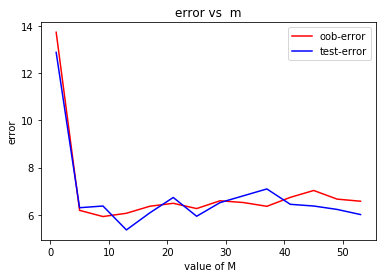

In [16]:
if __name__ == "__main__":
    random_forest()